<a href="https://colab.research.google.com/github/spandey5992/Knowledge_Discovery_In_Databases/blob/main/KDD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Index**
----


1.  [Imports and Tools](#1) <br>
    1-A. [Imports](#1-A) <br>
    1-B. [Progress bar display](#1-B) <br>
    1-C. [Requests manager](#1-C) <br>
2.   [Data Loading/Collection](#2) <br>
    2-A. [Gather data from the Spotify API](#2-A) <br>
    2-B. [Load dataset and show first 5 rows](#2-B) <br>
3.   [Data Cleaning](#3) <br>
    3-A. [Fix release dates](#3-A) <br>
    3-B. [Load covid dataset for a specific country](#3-B) <br>
4.   [Show missing values](#4) <br>
    4-A. [Plot missing values per country by week charted](#4-A) <br>
    4-B. [Plot missing values for the current country for each position missing in every week charted](#4-B) <br>
5.   [Data Visualization](#5) <br>
    5-A. [Genres](#5-A) <br>
    5-B. [Song features](#5-B) <br>









<a name="1"></a>
# 1. Imports and Tools
---



[link text](https://)<a name="1-A"></a>
## 1-A. Imports

In [ ]:
import json
import os
import re
import time
from datetime import date, timedelta, datetime

from matplotlib import pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import warnings

# Turns off warnings for pandas/numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

# Downloads all necessary files
if not os.path.exists('spotify_dataset.feather'):
    !gdown --id 1yki5ICaRcB5KY4psE4qVzqyGXxMGhFhE
if not os.path.exists('spotify_genre.feather'):
    !gdown --id 1DnHntMvoTZSnQhM12tBzdKYmTtSg7AB2
if not os.path.exists('spotify_dataset_us.csv'):
    !gdown --id 1lBMhg2_NBwD2NOM6VFLWX1N_TAPLd5oS
if not os.path.exists('owid-covid-data.csv'):
    !gdown --id 16QKydmHUopDbtkMAlK0v0OmJwLZFePwx

<a name="1-B"></a>
### 1-B. Progress bar display
This creates a loading bar to show progress for processes involving downloading/transforming data.

In [ ]:
#@title  { display-mode: "form" }
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


<a name="1-C"></a>
### 1-C. Requests manager
In order to prevent an API request from failing over a rate limit, we use this tool to retry the request on failure. 

In [ ]:
#@title  { display-mode: "form" }
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    backoff_factor=1,
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["HEAD", "GET", "OPTIONS"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", adapter)
http.mount("http://", adapter)


<a name="2"></a>
# 2. Data Loading/Collection
---

<a name="2-A"></a>
### 2-A. Gather data from the Spotify API (this takes a long time)
We need to use Spotify's API to collect information about a song such as its release date, genres, and audio features. Due to the time consuming nature of this code, we only have to run it if the result for this method was not already preloaded. 

In [ ]:
#@title  { display-mode: "form" }
if not os.path.exists("spotify_dataset.feather"):
    token = "<insert_token_here>"
    df = pd.read_csv("spotify_charts_dataset.csv", index_col=0)
    df["song_id"] = df.pop("id")
    df = df[df.song_id != "#"]
    df.pop("track")
    song_ids = df["song_id"].unique().tolist()
    audio_feature_cols = [
        "song_id",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
        "time_signature",
    ]
    afdf = pd.DataFrame()
    gdf = pd.DataFrame()
    out = display(progress(0, 100), display_id=True)

    i = 0
    while i < len(song_ids):
        out.update(progress(i / len(song_ids) * 100, 100))
        songs = song_ids[i : min(50 + i, len(song_ids))]
        url = f'https://api.spotify.com/v1/audio-features?ids={",".join(songs)}'
        req = http.get(
            url,
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            data = req.json()["audio_features"]

        except:
            if 'error' in req.json() and int(req.json()['error']['status']) == 401:
                token = input("Input new token: ")
                continue
            print(req.json())
            print(url)
            break
        for j, item in enumerate(data):
            if item is None:
                data[j] = {}
                data[j]["song_id"] = songs[j]
                for col in audio_feature_cols[1:]:
                    data[j][col] = None
                continue
            item["song_id"] = songs[j]

        audio_features_df = pd.DataFrame(data)[audio_feature_cols]
        url = f'https://api.spotify.com/v1/tracks?ids={",".join(songs)}'
        req = http.get(
            url,
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            data = req.json()["tracks"]
        except:
            if 'error' in req.json() and int(req.json()['error']['status']) == 401:
                token = input("Input new token: ")
                continue
            print(req.json())
            print(url)
            break

        artist_df = pd.DataFrame(
            [
                {
                    "song_id": songs[j],
                    "track": item["name"],
                    "release_date": item["album"]["release_date"],
                    "artist_id": item["artists"][0]["id"],
                }
                for j, item in enumerate(data)
            ]
        )

        combined_df = pd.merge(audio_features_df, artist_df, on="song_id")
        afdf = afdf.append(combined_df, ignore_index=True)

        i += min(50, len(song_ids) - i)
    artist_ids = afdf["artist_id"].unique().tolist()
    genre_df = pd.DataFrame()
    i = 0
    out = display(progress(0, 100), display_id=True)
    while i < len(artist_ids):
        out.update(progress(i / len(artist_ids) * 100, 100))
        artists = artist_ids[i : min(15 + i, len(artist_ids))]
        req = http.get(
            f'https://api.spotify.com/v1/artists?ids={",".join(artists)}',
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            data = req.json()["artists"]
        except:
            print(req.json())
            break

        for j, item in enumerate(data):
            item["id"] = artists[j]
            item["artist"] = item["name"]
        genre_df = genre_df.append(data, ignore_index=True)[["id", "artist", "genres"]]
        i += min(15, len(artist_ids) - i)

    genre_df["artist_id"] = genre_df.pop("id")
    afdf = pd.merge(afdf, genre_df, on="artist_id")

    df = pd.merge(df, afdf, on="song_id")
    df['genres'] = df['genres'].apply(lambda x: str(x))
    df.to_feather('spotify_dataset.feather')


<a name="2-B"></a>
### 2-B. Load dataset and show first 5 rows
There is a dropdown box that allows for the a certain country's spotify data to be selected. The data is then transformed to fit the needs of the notebook.

In [ ]:

#@title  { run: "auto", vertical-output: true, display-mode: "form" }
country = 'us' #@param ['us','all','global','ae', 'ar', 'at', 'au', 'be', 'bg', 'bo', 'br', 'ca', 'ch', 'cl', 'co', 'cr', 'cy', 'cz', 'de', 'dk', 'do', 'ec', 'ee', 'eg', 'es', 'fi', 'fr', 'gb', 'gr', 'gt', 'hk', 'hn', 'hu', 'id', 'ie', 'il', 'in', 'is', 'it', 'jp', 'kr', 'lt', 'lu', 'lv', 'ma', 'mx', 'my', 'ni', 'nl', 'no', 'nz', 'pa', 'pe', 'ph', 'pl', 'pt', 'py', 'ro', 'ru', 'sa', 'se', 'sg', 'sk', 'sv', 'th', 'tr', 'tw', 'ua', 'uy', 'vn', 'za']
df = pd.read_feather('spotify_dataset.feather')
if not country == 'all':
    # select the specified country
    df = df[df.country == country]
    # convert str of list to list
    df['genres'] = df['genres'].apply(lambda x: eval(x))
# remove incomplete rows
df.dropna(inplace=True)
# shorten release_date to just the year
df['release_date'] = df['release_date'].apply(lambda x: x.split('-')[0])
# country is changed to region because it conflicts with the genre of country that we add as a field later on
df['region'] = df.pop('country')
# convert week_charted to datetime format
df['week_charted'] = pd.to_datetime(df['week_charted'])
# sort values into a readable format
df = df.sort_values(['region','week_charted', 'position']).reset_index(drop=True)
df.head()


,position,streams,week_charted,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track,release_date,artist_id,artist,genres,region
0,1,8618267,2016-12-23,343YBumqHu19cGoGARUTsd,0.928,0.481,9.0,-9.350,0.0,0.2870,0.105,0.000000,0.176,0.613,134.007,210937.0,4.0,Fake Love,2017,3TVXtAsR1Inumwj472S9r4,Drake,"[canadian hip hop, canadian pop, hip hop, rap,...",us
1,2,7946032,2016-12-23,4Km5HrUvYTaSUfiSGPJeQR,0.927,0.665,11.0,-5.313,1.0,0.2440,0.061,0.000000,0.123,0.175,127.076,343150.0,4.0,Bad and Boujee (feat. Lil Uzi Vert),2017,6oMuImdp5ZcFhWP0ESe6mG,Migos,"[atl hip hop, pop rap, rap, trap]",us
2,3,7738517,2016-12-23,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7.0,-7.028,1.0,0.2820,0.165,0.000003,0.134,0.535,186.054,230453.0,4.0,Starboy,2016,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,"[canadian contemporary r&b, canadian pop, pop]",us
3,4,6209336,2016-12-23,6fujklziTHa8uoM5OQSfIo,0.794,0.632,0.0,-6.163,1.0,0.0649,0.142,0.000000,0.128,0.355,145.926,291893.0,4.0,Black Beatles,2016,7iZtZyCzp3LItcw1wtPI3D,Rae Sremmurd,"[hip hop, melodic rap, mississippi hip hop, po...",us
4,5,5813157,2016-12-23,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.000000,0.111,0.661,95.010,244960.0,4.0,Closer,2016,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,"[dance pop, edm, electropop, pop, pop dance, t...",us


<a name="3"></a>
# 3. Data Cleaning
----

There are a few cases where the release date on the song is incorrect and might point to a remastered version. This code will find the song's original release date so it can be used for visualization later. Be aware this takes a long time so you should only run this for countries that already have the result preloaded.

<a name="3-A"></a>
### 3-A. Fix release dates (this takes a long time)

In [ ]:
#@title  { display-mode: "form" }
fix_release_dates = True #@param {type:"boolean"}
if fix_release_dates and not os.path.exists(f'spotify_dataset_{country}.csv'):
    temp_df = df.drop_duplicates(['track', 'artist'])
    i = 0
    temp_df.dropna(inplace=True)
    counter = 0
    token = "<insert_token_here>"
    out = display(progress(0, len(temp_df)), display_id=True)    
    while i < len(temp_df): 
        out.update(progress(i , len(temp_df)))
        song = temp_df.iloc[i]
        url = f'https://api.spotify.com/v1/search'
        req = http.get(
            url,
            params={
                'q': song['track'] + ' ' + song['artist'],
                'type': 'track',
                'market': song['region']
            },
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            data = req.json()["tracks"]["items"][0]
        except:
            if 'error' in req.json() and int(req.json()['error']['status']) == 401:
                token = input("Input new token: ")
                continue
            i += 1
            continue
        if data['album']['release_date'].split('-')[0] != song['release_date']:
            if data['artists'][0]['name'] == song['artist'] and data['name'] == song['track']:
                temp_df.loc[temp_df.song_id == song.song_id, 'release_date'] = min(int(data['album']['release_date'].split('-')[0]), int(song['release_date']))
                counter += 1
        i += 1
    temp_df = df[df.columns.drop('release_date')].merge(temp_df[['release_date', 'track', 'artist']], on=['track', 'artist'])
    temp_df.to_csv(f'spotify_dataset_{country}.csv')
    del temp_df
if os.path.exists(f'spotify_dataset_{country}.csv') or fix_release_dates:
    df = df[df.columns.drop('release_date')].merge(pd.read_csv(f'spotify_dataset_{country}.csv')[['release_date', 'track', 'artist']].drop_duplicates(['track', 'artist']), on=['track', 'artist'])
    

<a name="3-B"></a>
### 3-B. Load covid dataset for a specific country
There is an option to select what country will be used to load the covid data .

In [ ]:
#@title Load covid dataset for a specific country { run: "auto", vertical-output: true, display-mode: "form" }
covid_country = "United States" #@param ["United States", "Afghanistan", "Africa", "Albania", "Algeria", "Andorra", "Angola", "Anguilla", "Antigua and Barbuda", "Argentina", "Armenia", "Aruba", "Asia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bermuda", "Bhutan", "Bolivia", "Bonaire Sint Eustatius and Saba", "Bosnia and Herzegovina", "Botswana", "Brazil", "British Virgin Islands", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia", "Cameroon", "Canada", "Cape Verde", "Cayman Islands", "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", "Cook Islands", "Costa Rica", "Cote d'Ivoire", "Croatia", "Cuba", "Curacao", "Cyprus", "Czechia", "Democratic Republic of Congo", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Europe", "European Union", "Faeroe Islands", "Falkland Islands", "Fiji", "Finland", "France", "French Polynesia", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Gibraltar", "Greece", "Greenland", "Grenada", "Guatemala", "Guernsey", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hong Kong", "Hungary", "Iceland", "India", "Indonesia", "International", "Iran", "Iraq", "Ireland", "Isle of Man", "Israel", "Italy", "Jamaica", "Japan", "Jersey", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kosovo", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Macao", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia (country)", "Moldova", "Monaco", "Mongolia", "Montenegro", "Montserrat", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Caledonia", "New Zealand", "Nicaragua", "Niger", "Nigeria", "Niue", "North America", "North Macedonia", "Northern Cyprus", "Norway", "Oceania", "Oman", "Pakistan", "Palau", "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Pitcairn", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Helena", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Sint Maarten (Dutch part)", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South America", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor", "Togo", "Tokelau", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Turks and Caicos Islands", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican", "Venezuela", "Vietnam", "Wallis and Futuna", "World", "Yemen", "Zambia", "Zimbabwe"]
cdf= pd.read_csv('owid-covid-data.csv')
cdf = cdf[cdf.location == covid_country]
cdf['week_date_ord'] = cdf['date'].apply(lambda date: pd.to_datetime(date).toordinal())
cdf.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,week_date_ord
119380,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737446
119381,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737447
119382,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,0.006,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737448
119383,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,0.006,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737449
119384,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,0.015,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,-9154.7,-3.68,-3.08,-27.498605,737450


Not all of the countries from the spotify dataset have logged top charted songs for each week up until 2016, so this chart will show which weeks are missing.

<a name="4"></a>
# 4. Showing Missing Values
---

<a name="4-A"></a>
### 4-A. Plot missing values per country by week charted

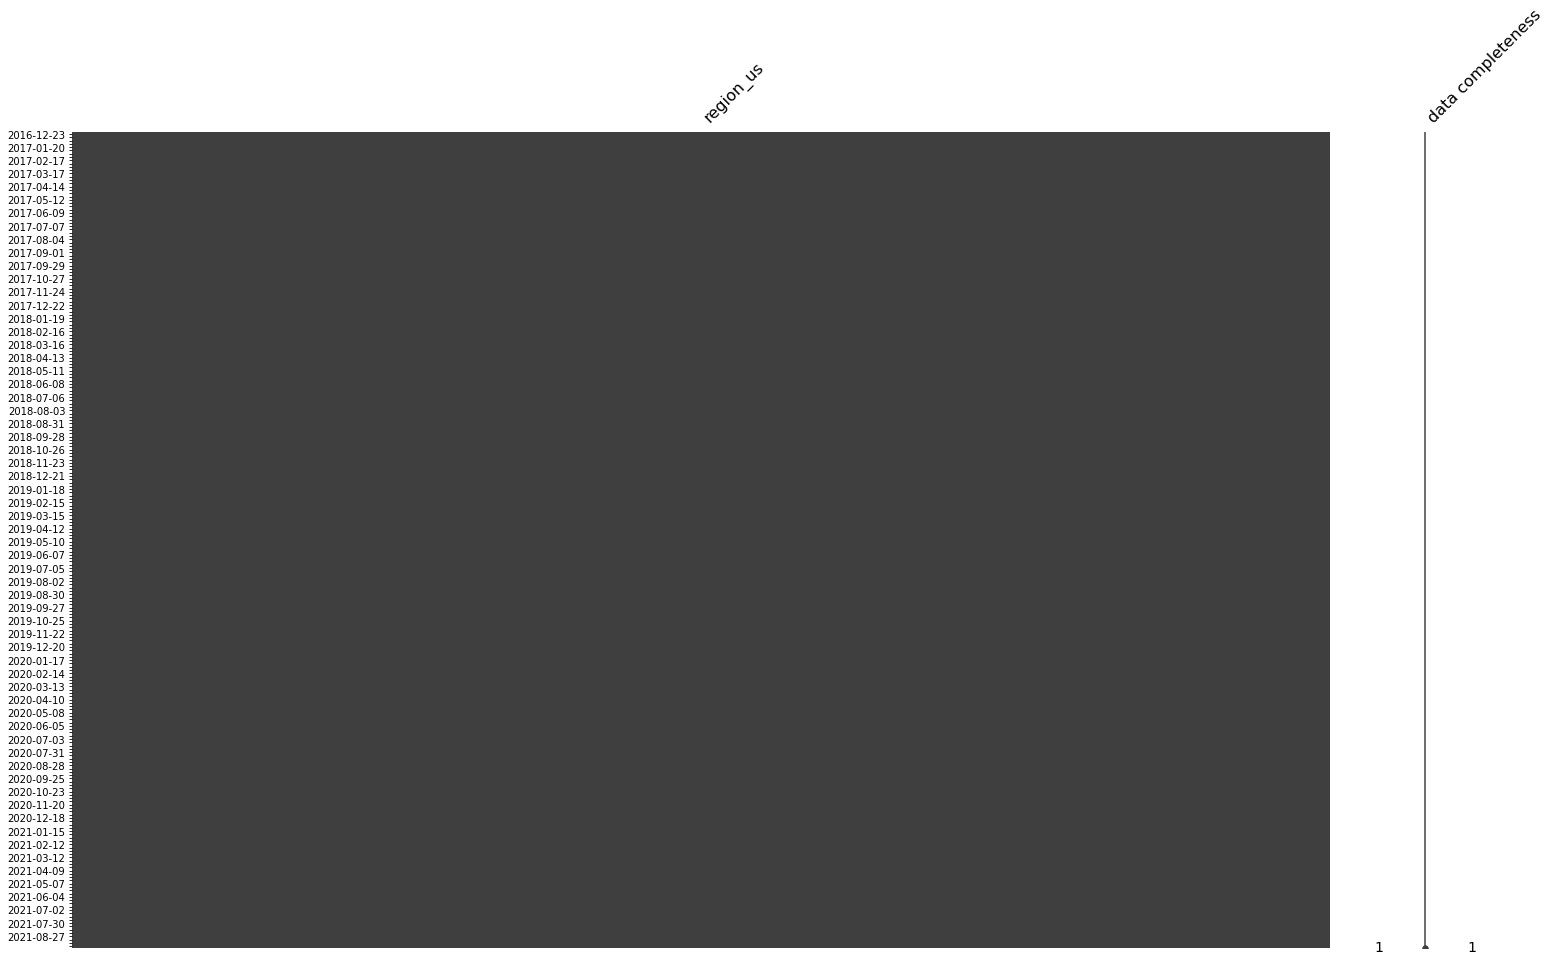

In [ ]:
#@title  { vertical-output: true, display-mode: "form" }
y = pd.get_dummies(df.region, prefix='region')
region_df = pd.concat([df[['week_charted']], y], axis=1)
region_df = region_df.groupby(by='week_charted', axis=0).sum()
region_df = region_df.reindex(pd.date_range('2016-12-23', max(df.week_charted.dt.date),freq='W-FRI'), method=None)
region_df = region_df.apply(lambda x: x.apply(lambda y: None if y == 0 else y))
ax = msno.matrix(region_df, figsize=(25,15),labels=True)
ax.set_yticks(range(len(region_df.index.unique())))
yticklabels = pd.date_range(region_df.index[0],region_df.index[-1], freq='W-FRI').map(lambda t: t.strftime('%Y-%m-%d')).tolist()
yticklabels[1::4] = map(lambda x: '', yticklabels[1::4])
yticklabels[2::4] = map(lambda x: '', yticklabels[2::4])
yticklabels[3::4] = map(lambda x: '', yticklabels[3::4])
ax.set_yticklabels(yticklabels, fontsize=10)
ax.yaxis.set_ticks_position('left')

<a name="4-B"></a>
### 4-B. Plot missing values for the current country for each position missing in every week charted
This graph shows where missing songs are in each week based on position in the week. It helps to click on the graph for a close up view. 

In [ ]:
#@title  { vertical-output: true, display-mode: "form" }
if country != 'all':
    y = pd.get_dummies(df.week_charted.dt.date)
    region_df = pd.concat([df[['position']], y], axis=1)
    region_df = region_df.groupby(by='position', axis=0).sum()
    region_df = region_df.apply(lambda x: x.apply(lambda y: None if y == 0 else y))
    msno.matrix(region_df, figsize=(100,10), labels=True)

<a name="5"></a>
# 5. Data Visualization
----

<a name="5-A"></a>
### 5-A. Genres

This code converts the genre to a multilabel version of a one-hot encoded matrix, then counts the number of times the genre has appeared based on week charted and region. The result has already been preloaded so there is no need to run it again. In order to run the original code, you will need 50+ GB of RAM which Colab does not offer in the free version. 

In [ ]:
#@title Generate a dataframe containing the count of each genre based on week charted and country { display-mode: "form" }
if not os.path.exists('spotify_genre.feather'):
  genre_set = set()
  df.drop_duplicates(subset = ["song_id"])['genres'].apply(lambda x: [genre_set.add(i) for i in x])
  genre_list = list(genre_set)
  genre_df = df[['song_id', 'genres']].drop_duplicates(subset = ["song_id"])
  v = genre_df.genres.values
  l = [len(x) for x in v.tolist()]
  f, u = pd.factorize(np.concatenate(v))
  n, m = len(v), u.size
  i = np.arange(n).repeat(l)
  dummies = pd.DataFrame(
      np.bincount(i * m + f, minlength=n * m).reshape(n, m),
      genre_df.index, u, dtype='int8')
  genre_df = genre_df.drop('genres', 1).join(dummies)
  genre_df = df[['song_id', 'week_charted', 'region']].merge(genre_df, on='song_id', how='inner')
  genre_week_df = genre_df.groupby(by=['week_charted', 'region'], squeeze=True)[genre_list].apply(lambda x: np.sum(x).astype('uint8'))
  genre_data=[] 
  def genre_flatten(x):
    for i,item in enumerate(x):
      genre_data.append([pd.to_datetime(x._name[0]),x._name[1],x.index[i],item])
  genre_week_df.apply(genre_flatten,axis=1)
  genre_week_df = pd.DataFrame(data = genre_data, columns=['week_date','region','category','count'])    
  genre_week_df['week_date_ord'] = data['week_date'].apply(lambda date: date.toordinal())
else:
    genre_week_df = pd.read_feather('spotify_genre.feather')
    genre_week_df = genre_week_df[genre_week_df.region == country]

Select the top 15 categories that have the biggest difference in mean between pre-pandemic and during the pandemic. Normalize each count based on its category.

In [ ]:
genre_week_df = genre_week_df[genre_week_df.region == country]
selected_categories = genre_week_df[genre_week_df['category'] != 0].groupby(['category']).apply(lambda x: abs((np.mean(x[x.week_date > datetime(2020,3,25)])-np.mean(x[x.week_date <= datetime(2020,3,25)]))/np.std(x[x.week_date <= datetime(2020,3,25)]))).sort_values(by='count', ascending=False).index.tolist()[0:15] 
category_mean = genre_week_df.groupby("category")["count"].mean()
category_std = genre_week_df.groupby("category")["count"].std()
def normalize(x):
    x['norm_count'] = (x['count']-category_mean[x['category']])/category_std[x['category']]
    return x
genre_week_df = genre_week_df.apply(normalize,axis=1)
genre_week_df.head()

In [ ]:
 important_dates = [{'date': '2020-01-21', 'label': 'First US Coronavirus case'}]

Then, we will graph the normalized popularity of each genre (blue line) along the with the number of new covid cases (red line) over time. 

In [ ]:
data = genre_week_df
cdf = cdf[cdf.week_date_ord.isin(data.week_date_ord.unique().tolist())]
fig, axes = plt.subplots(5,3, figsize=(60,50))
for i,ax in enumerate(axes.flatten()):
    sns.lineplot(x="week_date_ord", y="norm_count", data=data[data.category==selected_categories[i]], ax=ax)
    ax.axvline(pd.Timestamp(important_dates[0]['date']), linestyle='--')
    plt.text(pd.Timestamp(important_dates[0]['date'])+timedelta(days=5),100,important_dates[0]['label'],rotation=90)
    ax2 = ax.twinx()
    sns.lineplot(x="week_date_ord", y="new_cases", data=cdf, ax=ax2, color="r")
    ax.set_title(selected_categories[i], fontdict={'fontsize': 20})
    ax.set_xlim(data['week_date_ord'].min(), data['week_date_ord'].max())
    ax.set_xlabel('date')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)
plt.show()

<a name="5-B"></a>
### 5-B. Song features


Here, we plot the average audio analysis features (blue line) for each week charted and the number of new covid cases (red line) over time.

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(40,50))
feature_cols = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
data = df.groupby('week_charted')[feature_cols].mean().reset_index()
data['week_date_ord'] = data['week_charted'].apply(lambda date: date.toordinal())
for i,ax in enumerate(axes.flatten()):
    sns.lineplot(x="week_date_ord", y=feature_cols[i], data=data, ax=ax)
    ax2 = ax.twinx()
    sns.lineplot(x="week_date_ord", y="new_cases", data=cdf, ax=ax2, color="r")
    ax.set_title(feature_cols[i], fontdict={'fontsize': 20})
    ax.set_xlim(data['week_date_ord'].min(), data['week_date_ord'].max())
    ax.set_xlabel('date')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)
plt.show()

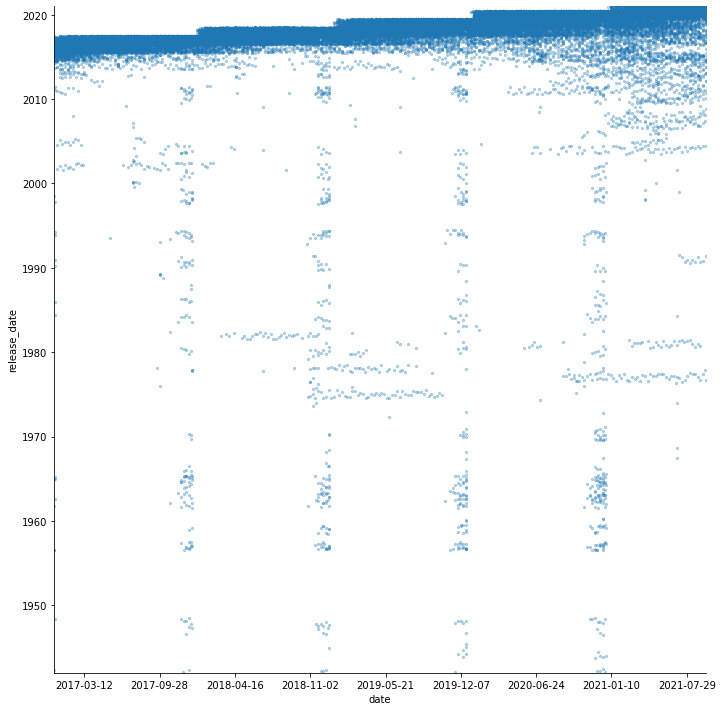

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
data = df
data['week_date_ord'] = data['week_charted'].apply(lambda date: date.toordinal())
data['release_date'] = data.release_date.apply(lambda x: int(x))
g = sns.lmplot(x='week_date_ord', y='release_date', data=data, palette='tab10', height=10, lowess=True,x_jitter=.5, y_jitter=.5,scatter_kws={"alpha":.3,"s": 5})
for ax in g.axes.flat:
    ax.set_xlim(data['week_date_ord'].min(), data['week_date_ord'].max())
    ax.set_ylim(data['release_date'].min(), data['release_date'].max())
    ax.set_xlabel('date')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)